In [83]:
import pandas as pd
import numpy as np
import random
import pickle
import gc
#import psycopg2
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [84]:
def train_test_split_by_date(df, train_fraction):
    train_idx = int(len(df) * train_fraction)
    train_end_date = df.loc[train_idx].game_date
    train = df[df['game_date'] < train_end_date]
    test = df[df['game_date'] >= train_end_date]
    return train, test

In [85]:
pitchers = ['Greinke', 'Scherzer', 'deGrom', 'Bauer']
models_path = '/home/ec2-user/SageMaker/RC-v1.2-Predictive-Modelling/best_model_pickles/'
pitcher_path = '/home/ec2-user/SageMaker/RC-v1.2-Predictive-Modelling/pitcher_df_pickles/'
models_df_list = []

for pitcher in pitchers:
    #best models pickle    
    models_df = pd.read_pickle(models_path+pitcher+'_binary_best_models_v1.pkl', compression='zip').reset_index(drop=True)
    models_df['name'] = pitcher
    pitcher_df = pd.read_pickle(pitcher_path+pitcher+'_df.pkl', compression='zip').reset_index(drop=True)
    pitcher_df['fastball_target'] = (pitcher_df['pitch_cat'] == 'fastball') * 1
    #train/test split
    train, test = train_test_split_by_date(pitcher_df, 0.85)
    #use the majority class of the train set as naive guess baseline for test prediction
    train_majority_class = train['fastball_target'].value_counts(normalize=True).index[0]
    models_df['baseline_majority'] = test['fastball_target'].value_counts(normalize=True)[train_majority_class]
    models_df['accuracy_minus_baseline'] = models_df['accuracy'] - models_df['baseline_majority']
    models_df_list.append(models_df)
    

best_models = pd.concat(models_df_list, sort=False).reset_index(drop=True)

In [89]:
best_models.sort_values('accuracy_minus_baseline', ascending=False).head(10)

,model,accuracy,f1_score,r2_score,roc_auc_score,model_type,name,baseline_majority,accuracy_minus_baseline
210,"LinearSVC(C=2.0, class_weight=None, dual=False...",0.598712,0.541667,-0.640073,N/A,LinearSVC,deGrom,0.427039,0.171674
170,"(DecisionTreeClassifier(class_weight=None, cri...",0.590129,0.547393,-0.675155,0.615691,RandomForestClassifier,deGrom,0.427039,0.163090
171,"(DecisionTreeClassifier(class_weight=None, cri...",0.587983,0.535109,-0.683925,0.620796,RandomForestClassifier,deGrom,0.427039,0.160944
180,([DecisionTreeRegressor(criterion='friedman_ms...,0.587983,0.516373,-0.683925,0.608191,GradientBoostingClassifier,deGrom,0.427039,0.160944
160,"(DecisionTreeClassifier(class_weight=None, cri...",0.585837,0.544811,-0.692696,0.623864,RandomForestClassifier,deGrom,0.427039,0.158798
161,"(DecisionTreeClassifier(class_weight=None, cri...",0.585837,0.555300,-0.692696,0.623308,RandomForestClassifier,deGrom,0.427039,0.158798
172,"(DecisionTreeClassifier(class_weight=None, cri...",0.584764,0.551564,-0.697081,0.619794,RandomForestClassifier,deGrom,0.427039,0.157725
162,"(DecisionTreeClassifier(class_weight=None, cri...",0.583691,0.535885,-0.701466,0.622278,RandomForestClassifier,deGrom,0.427039,0.156652
173,"(DecisionTreeClassifier(class_weight=None, cri...",0.582618,0.514357,-0.705851,0.613799,RandomForestClassifier,deGrom,0.427039,0.155579
163,"(DecisionTreeClassifier(class_weight=None, cri...",0.582618,0.546091,-0.705851,0.61659,RandomForestClassifier,deGrom,0.427039,0.155579


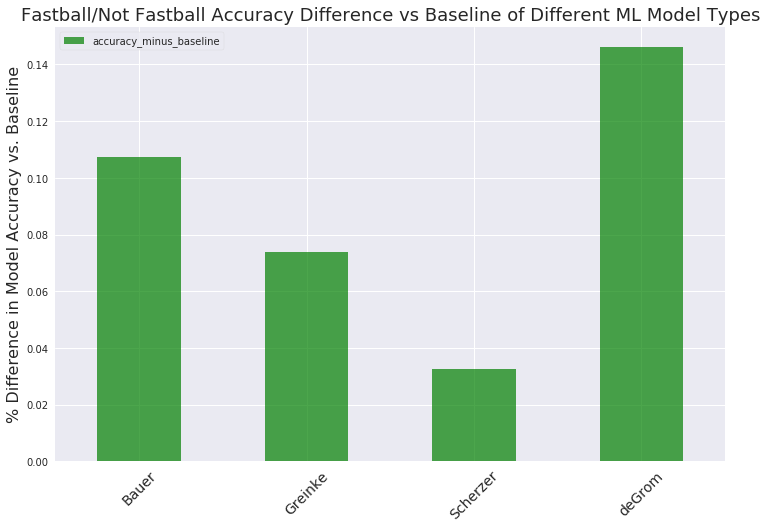

In [94]:
fig, ax = plt.subplots(figsize=[12,8])
plt.style.use('seaborn')

grouped = best_models.groupby(['name'])

accuracy_plot = grouped['accuracy_minus_baseline'].mean().plot(kind='bar', ax=ax, alpha=.7, color='green')
#grouped['accuracy'].mean().unstack('name').plot(kind='line', ax=ax, alpha=.9)
plt.xlabel('')
plt.ylabel('% Difference in Model Accuracy vs. Baseline', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.title('Fastball/Not Fastball Accuracy Difference vs Baseline of Different ML Model Types', fontsize=18)
ax.legend(loc=2, frameon=True)
plt.show()

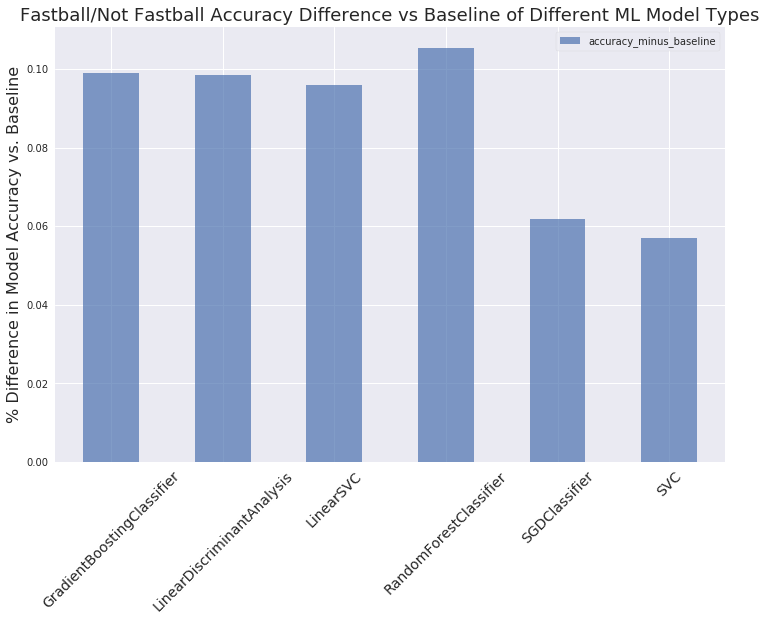

In [90]:
fig, ax = plt.subplots(figsize=[12,8])
plt.style.use('seaborn')

grouped = best_models.groupby(['model_type'])

accuracy_plot = grouped['accuracy_minus_baseline'].mean().plot(kind='bar', ax=ax, alpha=.7)
#grouped['accuracy'].mean().unstack('name').plot(kind='line', ax=ax, alpha=.9)
plt.xlabel('')
plt.ylabel('% Difference in Model Accuracy vs. Baseline', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.title('Fastball/Not Fastball Accuracy Difference vs Baseline of Different ML Model Types', fontsize=18)
ax.legend(loc=1, frameon=True)
plt.show()

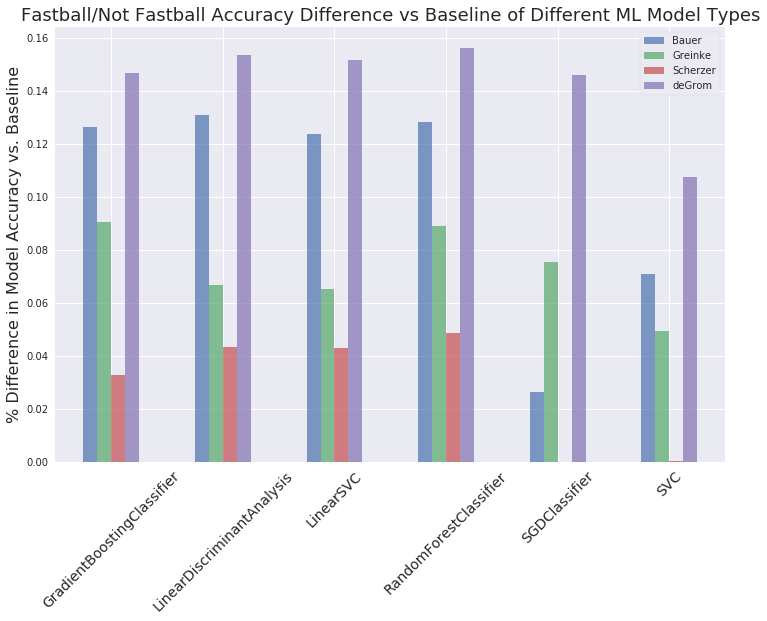

In [87]:
fig, ax = plt.subplots(figsize=[12,8])
plt.style.use('seaborn')

grouped = best_models.groupby(['model_type','name'])

accuracy_plot = grouped['accuracy_minus_baseline'].mean().unstack('name').plot(kind='bar', ax=ax, alpha=.7)
#grouped['accuracy'].mean().unstack('name').plot(kind='line', ax=ax, alpha=.9)
plt.xlabel('')
plt.ylabel('% Difference in Model Accuracy vs. Baseline', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.title('Fastball/Not Fastball Accuracy Difference vs Baseline of Different ML Model Types', fontsize=18)
ax.legend(loc=1, frameon=True)
plt.show()

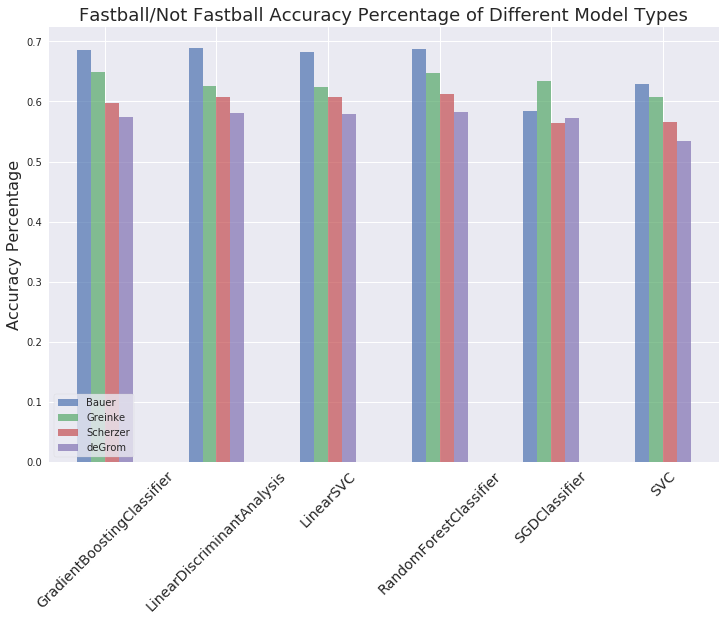

In [88]:
fig, ax = plt.subplots(figsize=[12,8])
plt.style.use('seaborn')

grouped = best_models.groupby(['model_type','name'])

accuracy_plot = grouped['accuracy'].mean().unstack('name').plot(kind='bar', ax=ax, alpha=.7)
#grouped['accuracy'].mean().unstack('name').plot(kind='line', ax=ax, alpha=.9)
plt.xlabel('')
plt.ylabel('Accuracy Percentage', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.title('Fastball/Not Fastball Accuracy Percentage of Different Model Types', fontsize=18)
ax.legend(loc=3, frameon=True)
plt.show()